In [8]:
import numpy as np
data=np.load("ch9_data.npz")
X=data["X"]
X0_min=data["X0_min"]
X0_max=data["X0_max"]
X1_min=data["X1_min"]
X1_max=data["X1_max"]

In [9]:
#ガウス関数
def gauss(x,mu,sigma):
    N=x.shape[0]
    y=np.zeros(N)
    inv_sigma=np.linalg.inv(sigma)
    a=1/(2*np.pi)*1/(np.linalg.det(sigma)**(1/2))
    for n in range(N):
        x_vec=np.array([x[n,0],x[n,1]])
        y[n]=a*np.exp(
            (-1/2)*(x_vec-mu).T@inv_sigma@(x_vec-mu)
        )
    return y

In [10]:
x=np.array([[1,2],[2,1],[3,4]])
mu=np.array([1,2])
sigma=np.array([[1,0],[0,1]])
print(gauss(x,mu,sigma))

[0.15915494 0.05854983 0.00291502]


In [11]:
#混合ガウスモデル
def mixgauss(x,pi,mu,sigma):
    N,D=x.shape
    K=len(pi)
    p=np.zeros(N)
    for k in range(K):
        p=p+pi[k]*gauss(x,mu[k,:],sigma[k,:,:])
    return p

In [12]:
x=np.array([[1,2],[2,2],[3,4]])
pi=np.array([0.3,0.7])
mu=np.array([[1,1],[2,2]])
sigma=np.array([[[1,0],[0,1]],[[2,0],[0,1]]])
print(mixgauss(x,pi,mu,sigma))

[0.09031182 0.09634263 0.00837489]


In [13]:
import matplotlib.pyplot as plt
#混合ガウス等高線表示
def show_contour_mixgauss(pi,mu,sigma):
    x0_n,x1_n=40,40
    x0=np.linspace(X0_min,X0_max,x0_n)
    x1=np.linspace(X1_min,X1_max,x1_n)
    xx0,xx1=np.meshgrid(x0,x1)
    x=np.c_[xx0.reshape(-1),xx1.reshape(-1)]
    f=mixgauss(x,pi,mu,sigma)
    f=f.reshape(x1_n,x0_n)
    plt.contour(xx0,xx1,f,levels=10,colors="gray")
#混合ガウスモデルサーフェス表示
def show3d_mixgauss(ax,pi,mu,sigma):
    x0_n,x1_n=40,40#サーフェス表示の解像度
    x0=np.linspace(X0_min,X0_max,x0_n)
    x1=np.linspace(X1_min,X1_max,x1_n)
    xx0,xx1=np.meshgrid(x0,x1)
    x=np.c_[xx0.reshape(-1),xx1.reshape(-1)]
    f=mixgauss(x,pi,mu,sigma)
    f=f.reshape(x0_n,x1_n)
    ax.plot_surface(
        xx0,xx1,f,
        rstride=2,cstride=2,alpha=0.3,color="blue",edgecolor="black",
    )


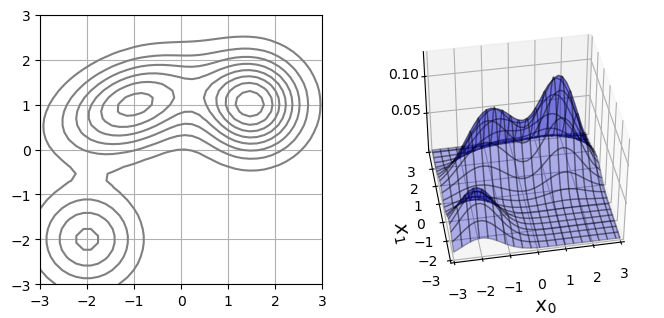

In [14]:

#test
pi=np.array([0.2,0.4,0.4])
mu=np.array([[-2,-2],[-1,1],[1.5,1]])
sigma=np.array([
    [[0.5,0],[0,0.5]],
    [[1,0.25],[0.25,0.5]],
    [[0.5,0],[0,0.5]],
])
plt.figure(figsize=(8,3.5))
#等高線表示
plt.subplot(1,2,1)
show_contour_mixgauss(pi,mu,sigma)
plt.grid()
#surface
ax=plt.subplot(1,2,2,projection="3d")
show3d_mixgauss(ax,pi,mu,sigma)
ax.set_zticks([0.05,0.10])
ax.set_xlabel("$x_0$",fontsize=14)
ax.set_ylabel("$x_1$",fontsize=14)
ax.view_init(40,-100)
plt.xlim(X0_min,X0_max)
plt.ylim(X1_min,X1_max)
plt.show()

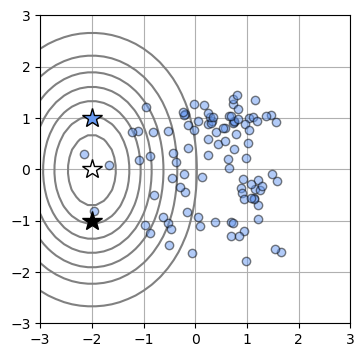

In [15]:
#パラメータの図示関数
def show_mixgauss_prm(x,ganma,pi,mu,sigma):
    cols=np.array([
        [0.4,0.6,0.95],
        [1,1,1],
        [0,0,0],
    ])
    N=x.shape[0]
    K=len(pi)
    show_contour_mixgauss(pi,mu,sigma)
    #データの描画
    for n in range(N):
        col=(
            ganma[n,0]*cols[0]
           +ganma[n,1]*cols[1]
           +ganma[n,2]*cols[2]
        )
        plt.plot(
            x[n,0],x[n,1],color=col,
            marker="o",markeredgecolor="black",
            markersize=6,alpha=0.5,
        )
    for k in range(K):
        plt.plot(
            mu[k,0],mu[k,1],color=cols[k],
            marker="*",markeredgecolor="black",
            markersize=15,markeredgewidth=1,
        )
    plt.grid() 
#main
N=X.shape[0]#行数
#パラメータの初期化
Pi=np.array([0.33,0.33,0.34])
Mu=np.array([[-2,1],[-2,0],[-2,-1]])
Sigma=np.array([[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]]])
Gamma=np.c_[np.ones((N,1)),np.zeros((N,2))]
#グラフ描画
plt.figure(figsize=(4,4))
show_mixgauss_prm(X,Gamma,Pi,Mu,Sigma)
plt.show()

In [16]:
#gammaを更新する(estep)
def e_step_mixgauss(x,pi,mu,sigma):
    N=x.shape[0]
    K=len(pi)
    y=np.zeros((N,K))
    #gaussfunctionの計算
    for k in (range(K)):
        y[:,k]=gauss(x,mu[k,:],sigma[k,:,:])
    #式9-16で負担率gammaを計算
    gamma=np.zeros((N,K))
    for n in range(N):
        a=np.zeros(K)
        for k in range(K):
            a[k]=pi[k]*y[n,k]
        gamma[n,:]=a/np.sum(a)
    return gamma

#main
Gamma=e_step_mixgauss(X,Pi,Mu,Sigma)

In [17]:
print(Gamma)

[[0.53290794 0.36981839 0.09727367]
 [0.05170748 0.29787695 0.65041557]
 [0.35723698 0.43863061 0.20413241]
 [0.55078604 0.36001926 0.0891947 ]
 [0.49501817 0.38907383 0.115908  ]
 [0.53874423 0.36666816 0.09458761]
 [0.21934825 0.44242263 0.33822912]
 [0.05587918 0.30657997 0.63754084]
 [0.2111526  0.4405145  0.3483329 ]
 [0.23266015 0.44489255 0.3224473 ]
 [0.32082481 0.44510989 0.2340653 ]
 [0.4883838  0.39222372 0.11939248]
 [0.04721561 0.28781224 0.66497215]
 [0.06641778 0.32623198 0.60735024]
 [0.51723484 0.37803888 0.10472628]
 [0.27715987 0.44816594 0.27467419]
 [0.0736976  0.3381663  0.5881361 ]
 [0.51583686 0.37875489 0.10540825]
 [0.5747406  0.34621259 0.07904681]
 [0.54159832 0.36511032 0.09329136]
 [0.0729414  0.33698157 0.59007704]
 [0.64638501 0.30062179 0.0529932 ]
 [0.49646273 0.38837897 0.1151583 ]
 [0.14187799 0.40969984 0.44842217]
 [0.59666518 0.33292507 0.07040975]
 [0.02819425 0.23423271 0.73757304]
 [0.55411361 0.35814704 0.08773935]
 [0.38734027 0.43093787 0.18

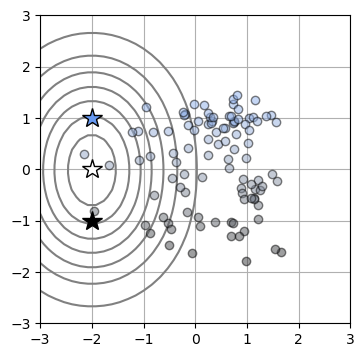

In [18]:
#パラメータ表示
plt.figure(figsize=(4,4))
show_mixgauss_prm(X,Gamma,Pi,Mu,Sigma)
plt.show()

In [19]:
Gamma

array([[0.53290794, 0.36981839, 0.09727367],
       [0.05170748, 0.29787695, 0.65041557],
       [0.35723698, 0.43863061, 0.20413241],
       [0.55078604, 0.36001926, 0.0891947 ],
       [0.49501817, 0.38907383, 0.115908  ],
       [0.53874423, 0.36666816, 0.09458761],
       [0.21934825, 0.44242263, 0.33822912],
       [0.05587918, 0.30657997, 0.63754084],
       [0.2111526 , 0.4405145 , 0.3483329 ],
       [0.23266015, 0.44489255, 0.3224473 ],
       [0.32082481, 0.44510989, 0.2340653 ],
       [0.4883838 , 0.39222372, 0.11939248],
       [0.04721561, 0.28781224, 0.66497215],
       [0.06641778, 0.32623198, 0.60735024],
       [0.51723484, 0.37803888, 0.10472628],
       [0.27715987, 0.44816594, 0.27467419],
       [0.0736976 , 0.3381663 , 0.5881361 ],
       [0.51583686, 0.37875489, 0.10540825],
       [0.5747406 , 0.34621259, 0.07904681],
       [0.54159832, 0.36511032, 0.09329136],
       [0.0729414 , 0.33698157, 0.59007704],
       [0.64638501, 0.30062179, 0.0529932 ],
       [0.

In [20]:
#pi,mu,SIgmaを更新する
def m_step_mixgauss(x,gamma):
    N,D=x.shape
    K=gamma.shape[1]
    #式9-17でN_kを計算
    N_k=np.sum(gamma,axis=0)
    #式9-18でpiを計算
    pi=N_k/N
    #式9-19でmuを計算
    mu=np.zeros((K,D))
    for k in range(K):
        for d in range(D):
            mu[k,d]=gamma[:,k]@x[:,d]/N_k[k]
    #式9-20でsigmaを計算
    sigma=np.zeros((K,D,D))
    for k in range(K):
        sigma_k=np.zeros((D,D))
        for n in range(N):
            x_mu=x[n,:]-mu[k,:]#x-mu
            x_mu=x_mu.reshape(2,1)
            sigma_k=sigma_k+gamma[n,k]*x_mu@x_mu.T
        sigma[k,:,:]=sigma_k/N_k[k]
    return pi,mu,sigma
#main
Pi,Mu,Sigma=m_step_mixgauss(X,Gamma)

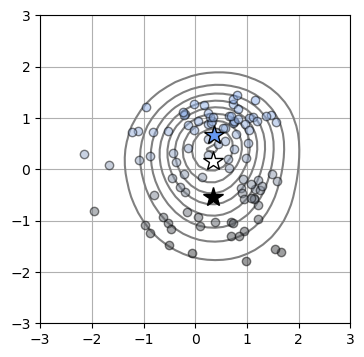

In [21]:
#パラメータ表示
plt.figure(figsize=(4,4))
show_mixgauss_prm(X,Gamma,Pi,Mu,Sigma)
plt.show()

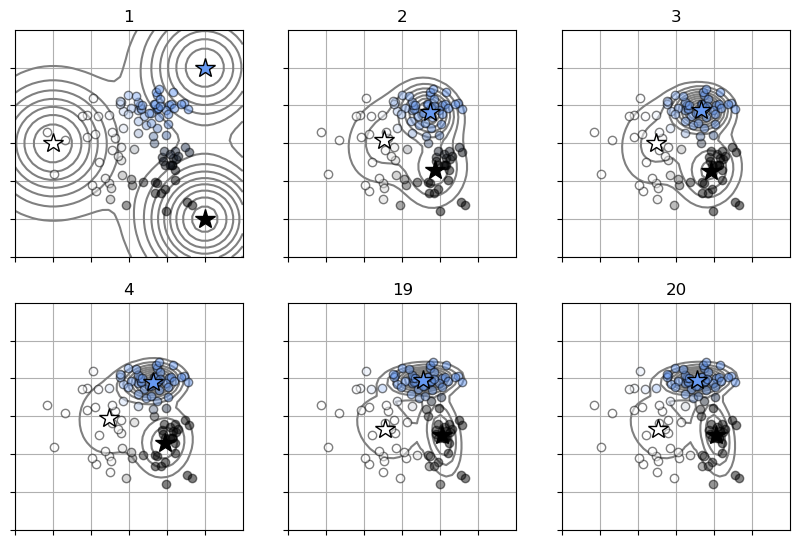

In [29]:
#パラメータの初期化
import numpy as np
Pi=np.array([0.3,0.3,0.4])
Mu=np.array([[2,2],[-2,0],[2,-2]])
Sigma=np.array([[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]]])
Gamma=np.c_[np.ones((N,1)),np.zeros((N,2))]
max_it=20
#main
plt.figure(figsize=(10,6.5))
i_subplot=1
for it in range(0,max_it):
    Gamma=e_step_mixgauss(X,Pi,Mu,Sigma)#E-step
    if it<4 or it>17:
        plt.subplot(2,3,i_subplot)
        show_mixgauss_prm(X,Gamma,Pi,Mu,Sigma)
        plt.title("{0:d}".format(it+1))
        plt.xticks(range(X0_min,X0_max),"")
        plt.yticks(range(X1_min,X1_max),"")
        i_subplot=i_subplot+1
    Pi,Mu,Sigma=m_step_mixgauss(X,Gamma)
plt.show()

In [31]:
#混合ガウスの誤差関数
def nlh_mixgauss(x,pi,mu,sigma):
    #x:NxD
    #pi:Kx1
    #mu:KxD
    #sigma:KxDxD
    #output err:NxK
    N=x.shape[0]
    K=len(pi)
    #calculate gaussfunction's value
    y=np.zeros((N,K))
    for k in range(K):
        y[:,k]=gauss(x,mu[k,:],sigma[k,:,:])
    #式9-22で対数尤度の計算
    lh=0
    for n in range(N):
        sum_pi_g=0
        for k in range(K):
            sum_pi_g=sum_pi_g+pi[k]*y[n,k]
        lh=lh+np.log(sum_pi_g)
    #error functionに変換
    err=-lh
    return err

Err= [426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


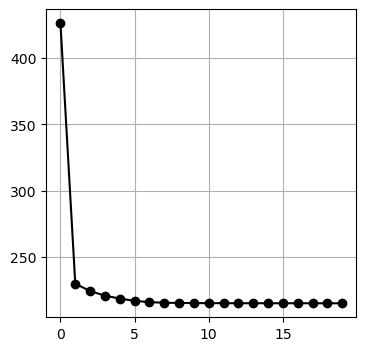

In [33]:
#パラメータの初期化
Pi=np.array([0.3,0.3,0.4])
Mu=np.array([[2,2],[-2,0],[2,-2]])
Sigma=np.array([[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]]])
Gamma=np.c_[np.ones((N,1)),np.zeros((N,2))]

#errorfunctionの計算
max_it=20
it=0
Err=np.zeros(max_it)
for it in range(0,max_it):
    Gamma=e_step_mixgauss(X,Pi,Mu,Sigma)
    Err[it]=nlh_mixgauss(X,Pi,Mu,Sigma)
    Pi,Mu,Sigma=m_step_mixgauss(X,Gamma)
#result
print('Err=',np.round(Err,2))
#glaph
plt.figure(figsize=(4,4))
plt.plot(np.arange(max_it),Err,"black",linestyle="-",marker="o")
plt.grid()
plt.show()